In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import os
import sys
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Rescaling,
    Input,
    BatchNormalization, 
    Add, 
    Activation
)
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing import image
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Disable tenforflow information messages about GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Disable tenforflow information messages 
tf.get_logger().setLevel('ERROR')
# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)
# Set the random seed


2023-05-23 19:24:16.414032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 19:24:17.411970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-23 19:24:19.847856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 19:24:20.008793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-23 19:24:20.009209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

Params

In [3]:
random_seed = 42
batch_size = 16
image_size = (350, 350)
input_shape = (350, 350, 3)
color_mode = "rgb"
seed_train_validation = 42
shuffle_value = True
validation_split = 0.25

Load Dataset

In [12]:
# Load the dataset

train_data_dir = "dataset/mvtec/tile/train/"
test_data_dir = "dataset/mvtec/tile/test/"


train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_data_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = image_size,
    validation_split = validation_split,
    subset = "training",
    seed = seed_train_validation,
    color_mode = color_mode,
    shuffle = shuffle_value
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size = image_size,
    validation_split = validation_split,
    subset = "validation",
    seed = seed_train_validation,
    color_mode = color_mode,
    shuffle = shuffle_value
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_data_dir,
    labels='inferred',
    label_mode='int',
    image_size = image_size,
    seed = seed_train_validation,
    color_mode = color_mode,
    shuffle = shuffle_value
    )


Found 418 files belonging to 2 classes.
Using 314 files for training.
Found 418 files belonging to 2 classes.
Using 104 files for validation.
Found 15 files belonging to 2 classes.


2023-05-23 19:25:12.323045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [314]
	 [[{{node Placeholder/_4}}]]
2023-05-23 19:25:12.323388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [314]
	 [[{{node Placeholder/_0}}]]


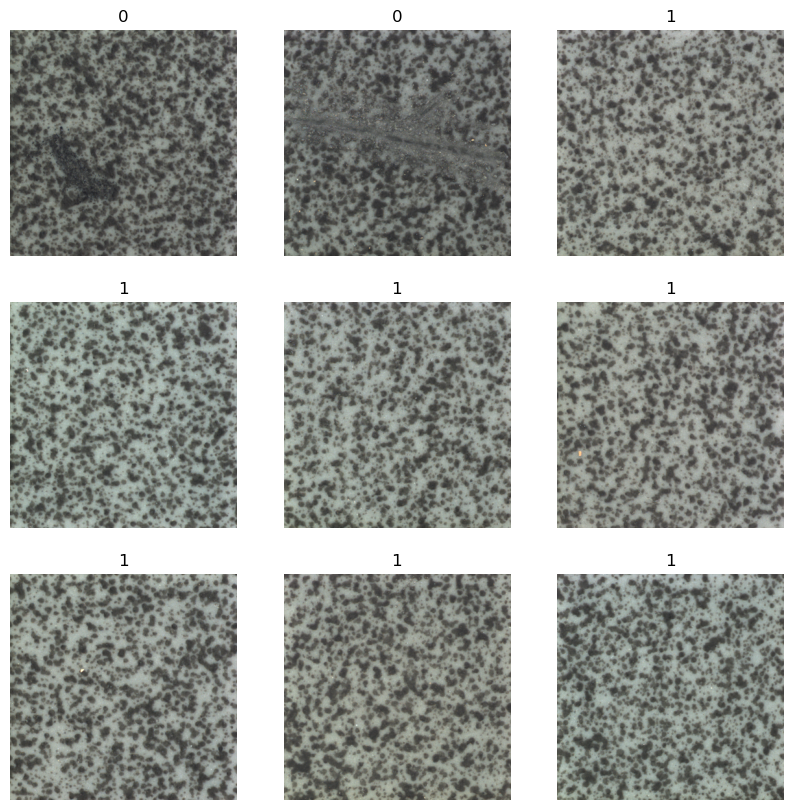

In [13]:
# plot some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")
        

In [14]:
# Data augmentation layer 
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)


In [15]:
# Create a rescaling layer

scaling_layer = Rescaling(1.0 / 255)

# Scale the datasets
train_data_scaled = train_ds.map(lambda x, y: (scaling_layer(x), y))
test_data_scaled = test_ds.map(lambda x, y: (scaling_layer(x), y))
val_data_scaled = val_ds.map(lambda x, y: (scaling_layer(x), y))

# Test that the scaling has worked by printing the min and max value from one the images
image_batch, labels_batch = next(iter(train_data_scaled))



2023-05-23 19:25:20.432382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [314]
	 [[{{node Placeholder/_4}}]]
2023-05-23 19:25:20.432655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [314]
	 [[{{node Placeholder/_0}}]]


In [16]:
# Autotune the datasets
AUTOTUNE = tf.data.AUTOTUNE

train_data_scaled = train_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)
test_data_scaled = test_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)
val_data_scaled = val_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)


In [17]:
# define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=15,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_checkpoint = ModelCheckpoint(
    "models/model.{epoch:02d}-{val_loss:.2f}.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
callback_list = [early_stopping, reduce_lr, model_checkpoint]


Models 

In [18]:
#simple_conv_model

simple_conv_model = Sequential([
    data_augmentation,

    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the simple_conv_model
simple_conv_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
        
# Print the simple_conv_model summary
# simple_conv_model.summary()

# Train the simple_conv_model
epochs = 100
simple_conv_model_history = simple_conv_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list,
)
# eval and plot simple conv model 
# Evaluate the simple_conv_model on the test data using `evaluate`
print("Evaluate on test data")
results = simple_conv_model.evaluate(test_data_scaled, batch_size=32)
print("test loss, test acc:", results)



Epoch 1/100


2023-05-23 19:25:24.464461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [314]
	 [[{{node Placeholder/_4}}]]
2023-05-23 19:25:24.464760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [314]
	 [[{{node Placeholder/_4}}]]
2023-05-23 19:25:26.444102: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Input is empty.
	 [[{{node decode_image/DecodeImage}}]]


 8/20 [===========>..................] - ETA: 1s - loss: 1.3456 - accuracy: 0.4688

2023-05-23 19:25:28.051185: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
2023-05-23 19:25:28.051255: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_24]]


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_24]]
  (1) INVALID_ARGUMENT:  Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8162]

In [11]:
# keras vgg16 model
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D

# Load the VGG16 model without the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the VGG16 model
vgg16_base.trainable = False

# Create a sequential model
vgg16_model = Sequential([
    data_augmentation,
    vgg16_base,  # Add the VGG16 base model
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the VGG16 model
vgg16_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the VGG16 model
epochs = 100
vgg16_model_history = vgg16_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list
)


Epoch 1/100


2023-05-23 19:24:41.931434: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Input is empty.
	 [[{{node decode_image/DecodeImage}}]]


 8/20 [===========>..................] - ETA: 2s - loss: 0.6935 - accuracy: 0.6406

2023-05-23 19:24:50.517085: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
2023-05-23 19:24:50.517166: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[sequential_2/sequential/random_rotation/transform/Shape/_6]]


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[sequential_2/sequential/random_rotation/transform/Shape/_6]]
  (1) INVALID_ARGUMENT:  Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_5290]

In [ ]:
# keras Inception model

from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D

# Load the InceptionV3 model without the top classification layer
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the InceptionV3 model
inception_base.trainable = False

# Create a sequential model
inception_model = Sequential([
    data_augmentation,
    inception_base,  # Add the InceptionV3 base model
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the InceptionV3 model
inception_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the InceptionV3 model
epochs = 100
inception_model_history = inception_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list
)




Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.6462
Epoch 1: val_loss did not improve from 0.25441
48/48 [==============================] - 17s 231ms/step - loss: 0.6411 - accuracy: 0.6462 - val_loss: 0.6071 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.7023
Epoch 2: val_loss did not improve from 0.25441
48/48 [==============================] - 6s 133ms/step - loss: 0.5841 - accuracy: 0.7023 - val_loss: 0.5671 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7350
Epoch 3: val_loss did not improve from 0.25441
48/48 [==============================] - 6s 133ms/step - loss: 0.5459 - accuracy: 0.7350 - val_loss: 0.5142 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7428
Epoch 4: val_loss did not improve from 0.25441

In [ ]:
# keras mobilenet model
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D

# Load the MobileNet model without the top classification layer
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the MobileNet model
mobilenet_base.trainable = False

# Create a sequential model
mobilenet_model = Sequential([
    data_augmentation,
    mobilenet_base,  # Add the MobileNet base model
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the MobileNet model
mobilenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the MobileNet model
epochs = 100
mobilenet_model_history = mobilenet_model.fit(
    train_data_scaled,
    validation_data=val_data_scaled,
    epochs=epochs,
    callbacks=callback_list
)



Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7298
Epoch 1: val_loss did not improve from 0.23816
48/48 [==============================] - 7s 98ms/step - loss: 0.5613 - accuracy: 0.7298 - val_loss: 0.4274 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 2/100
47/48 [============================>.] - ETA: 0s - loss: 0.3856 - accuracy: 0.8258
Epoch 2: val_loss did not improve from 0.23816
48/48 [==============================] - 3s 70ms/step - loss: 0.3849 - accuracy: 0.8264 - val_loss: 0.3152 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 3/100
47/48 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8617
Epoch 3: val_loss did not improve from 0.23816
48/48 [==============================] - 3s 69ms/step - loss: 0.3068 - accuracy: 0.8616 - val_loss: 0.2790 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8760
Epoch 4: val_loss did not improve from 0.23816
48/

dataset/mvtec/screw/train/


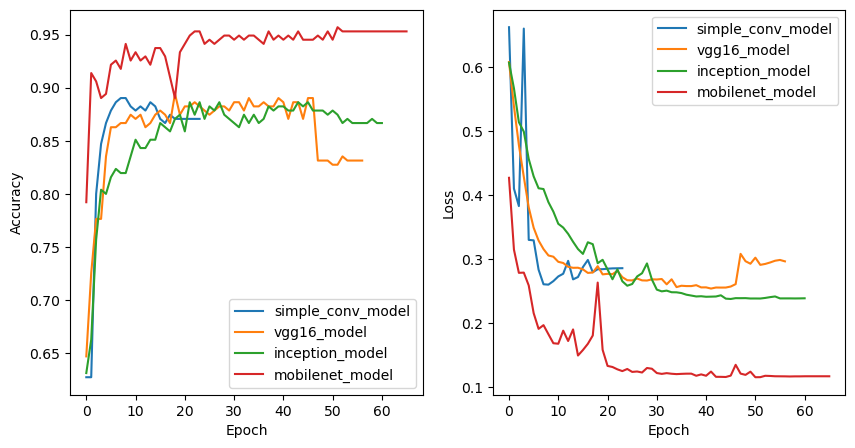

Evaluate on test data
1/1 [==============================] - 0s 35ms/step - loss: 0.6548 - accuracy: 0.6667
simple_conv_model test loss, test acc: [0.6547572016716003, 0.6666666865348816]
1/1 [==============================] - 0s 167ms/step - loss: 0.5141 - accuracy: 0.7333
vgg16_model test loss, test acc: [0.5141094326972961, 0.7333333492279053]
1/1 [==============================] - 0s 94ms/step - loss: 0.3022 - accuracy: 0.8667
inception_model test loss, test acc: [0.30224910378456116, 0.8666666746139526]
1/1 [==============================] - 0s 53ms/step - loss: 0.2570 - accuracy: 0.9333
mobilenet_model test loss, test acc: [0.2570389211177826, 0.9333333373069763]


In [ ]:
# python funciton that take the history of four models and comare them in a plot {val_loss, val_accuracy}

def compare_history(history1, history2, history3, history4):
    # Plot the model accuracy and loss curves using `matplotlib`
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history["val_accuracy"], label="simple_conv_model")
    plt.plot(history2.history["val_accuracy"], label="vgg16_model")
    plt.plot(history3.history["val_accuracy"], label="inception_model")
    plt.plot(history4.history["val_accuracy"], label="mobilenet_model")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history1.history["val_loss"], label="simple_conv_model")
    plt.plot(history2.history["val_loss"], label="vgg16_model")
    plt.plot(history3.history["val_loss"], label="inception_model")
    plt.plot(history4.history["val_loss"], label="mobilenet_model")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    # Evaluate on test data
    print("Evaluate on test data")
    results = history1.model.evaluate(test_data_scaled, batch_size=32)
    print("simple_conv_model test loss, test acc:", results)
    results = history2.model.evaluate(test_data_scaled, batch_size=32)
    print("vgg16_model test loss, test acc:", results)
    results = history3.model.evaluate(test_data_scaled, batch_size=32)
    print("inception_model test loss, test acc:", results)
    results = history4.model.evaluate(test_data_scaled, batch_size=32)
    print("mobilenet_model test loss, test acc:", results)
    
    

# compare the four models
print(train_data_dir)
compare_history(simple_conv_model_history, vgg16_model_history, inception_model_history, mobilenet_model_history)
